In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

y_valid = pd.read_csv('data/processed/y_valid.csv') 

Optimal weight for NN predictions: 0.23
Best RMSE on Validation set: 19099.777222673623


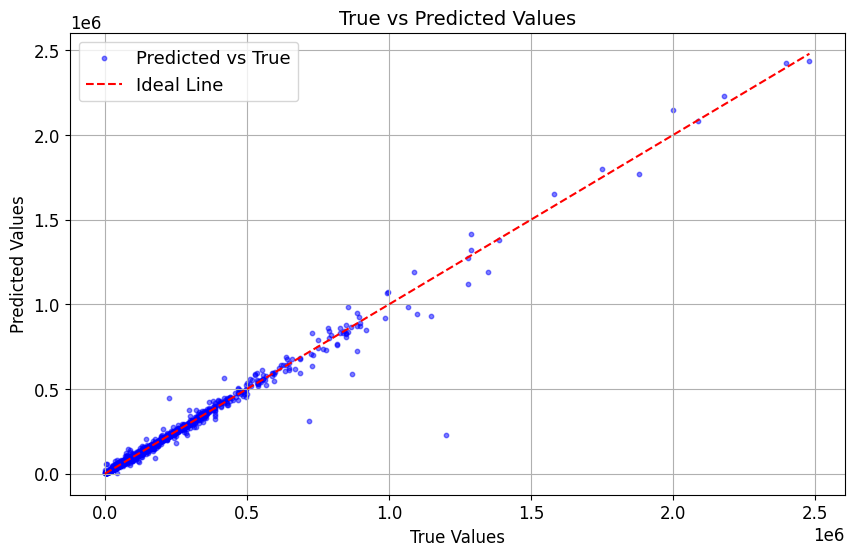

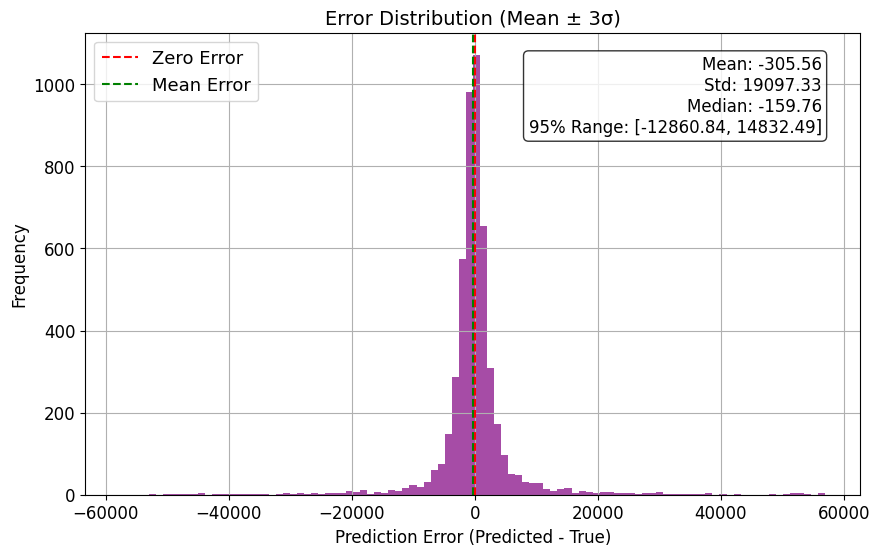


Error Statistics:
Mean Error: -305.56
Error Standard Deviation: 19097.33
Error Median: -159.76
Error Interquartile Range: 2949.61
95% Error Range: [-12860.84, 14832.49]


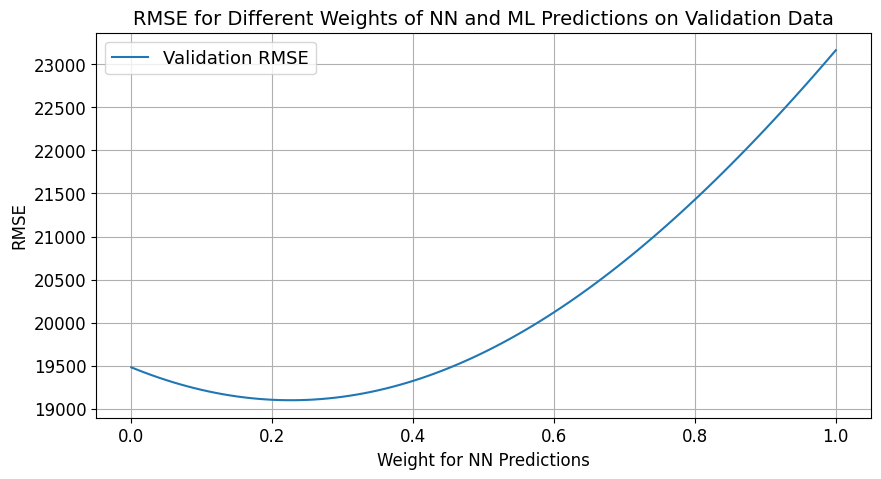

Optimal weight for NN predictions: 0.23
Best RMSE on Validation set: 19099.777222673623
Combined test predictions saved to data/combined_test_predictions.csv
Combined test predictions saved to data/fullml_combined_test_predictions.csv


In [2]:
def visualize_combined_predictions(y_valid, nn_valid, ml_valid, best_weight):
    # Ensure all inputs are numpy arrays
    if isinstance(y_valid, pd.Series):
        y_valid = y_valid.values
    elif isinstance(y_valid, pd.DataFrame):
        y_valid = y_valid.values.ravel()
    
    # Convert predictions to numpy arrays
    nn_predictions = nn_valid['Predicted'].values
    ml_predictions = ml_valid['Predicted'].values
    
    # Calculate combined predictions
    combined_predictions = best_weight * nn_predictions + (1 - best_weight) * ml_predictions
    
    plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 13
})
    
    # 1. True vs Predicted scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_valid, combined_predictions, alpha=0.5, color='blue', s=10)
    
    # Add ideal line
    min_val = min(np.min(y_valid), np.min(combined_predictions))
    max_val = max(np.max(y_valid), np.max(combined_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Values')
    plt.grid(True)
    plt.legend(['Predicted vs True', 'Ideal Line'])
    plt.show()

    # 2. Error distribution histogram with adjusted parameters
    plt.figure(figsize=(10, 6))
    errors = combined_predictions - y_valid
    
    # Calculate error statistics for reasonable display range
    error_mean = np.mean(errors)
    error_std = np.std(errors)
    
    # Set display range to mean ± 3 std
    x_min = error_mean - 3*error_std
    x_max = error_mean + 3*error_std
    
    # Plot histogram with more bins and limited x-axis range
    plt.hist(errors, bins=100, color='purple', alpha=0.7, 
             range=(x_min, x_max))  # Limit to main interval
    plt.axvline(x=0, color='red', linestyle='--')
    plt.axvline(x=error_mean, color='green', linestyle='--')
    
    plt.xlabel('Prediction Error (Predicted - True)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution (Mean ± 3σ)')
    plt.grid(True)
    plt.legend(['Zero Error', 'Mean Error'], loc='upper left')
    
    # Add statistics text box
    stats_text = f'Mean: {error_mean:.2f}\nStd: {error_std:.2f}\n'
    stats_text += f'Median: {np.median(errors):.2f}\n'
    stats_text += f'95% Range: [{np.percentile(errors, 2.5):.2f}, {np.percentile(errors, 97.5):.2f}]'
    
    plt.text(0.95, 0.95, stats_text,
             transform=plt.gca().transAxes,
             verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()
    
    # Print detailed error statistics
    print(f"\nError Statistics:")
    print(f"Mean Error: {error_mean:.2f}")
    print(f"Error Standard Deviation: {error_std:.2f}")
    print(f"Error Median: {np.median(errors):.2f}")
    print(f"Error Interquartile Range: {np.percentile(errors, 75) - np.percentile(errors, 25):.2f}")
    print(f"95% Error Range: [{np.percentile(errors, 2.5):.2f}, {np.percentile(errors, 97.5):.2f}]")
    
def load_and_combine_predictions(valid_file_nn, valid_file_ml, test_file_nn, test_file_ml, test_full_file_ml, y_valid):
    # Load data
    nn_valid = pd.read_csv(valid_file_nn)
    ml_valid = pd.read_csv(valid_file_ml)
    nn_test = pd.read_csv(test_file_nn)
    ml_test = pd.read_csv(test_file_ml)
    full_ml_test = pd.read_csv(test_full_file_ml)
    
    # Assuming y_valid is a numpy array containing the actual validation targets
    # y_valid = np.array([...]) # Uncomment this if y_valid needs to be manually input

    # Optimal weights search
    weights = np.linspace(0, 1, 101)  # Creates 101 points from 0 to 1
    rmses = []
    best_rmse = float('inf')
    best_weight = None

    for weight in weights:
        # Combine predictions for validation set
        combined_valid_predictions = weight * nn_valid['Predicted'] + (1 - weight) * ml_valid['Predicted']
        rmse = np.sqrt(mean_squared_error(y_valid, combined_valid_predictions))
        rmses.append(rmse)

        if rmse < best_rmse:
            best_rmse = rmse
            best_weight = weight
            
    print(f'Optimal weight for NN predictions: {best_weight}')
    print(f'Best RMSE on Validation set: {best_rmse}')
    
    # Add visualization call
    visualize_combined_predictions(y_valid, nn_valid, ml_valid, best_weight)

    # Plotting RMSE vs. weights
    plt.figure(figsize=(10, 5))
    plt.plot(weights, rmses, label='Validation RMSE')
    plt.xlabel('Weight for NN Predictions')
    plt.ylabel('RMSE')
    plt.title('RMSE for Different Weights of NN and ML Predictions on Validation Data')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f'Optimal weight for NN predictions: {best_weight}')
    print(f'Best RMSE on Validation set: {best_rmse}')

    # # Combine test set predictions using optimal weight
    combined_test_predictions = best_weight * nn_test['Predicted'] + (1 - best_weight) * ml_test['Predicted']
    # test_rmse = np.sqrt(mean_squared_error(nn_test['Predicted'], combined_test_predictions))  # Example, replace nn_test['Predicted'] with actual y_test if available

    # # Save combined test predictions
    combined_test_df = pd.DataFrame({
        'Id': nn_test['Id'],
        'Predicted': combined_test_predictions
    })
    combined_test_df.to_csv('data/combined_test_predictions.csv', index=False)
    print("Combined test predictions saved to data/combined_test_predictions.csv")
    # print(f'RMSE on Test set: {test_rmse}')
    
    fullml_combined_test_predictions = best_weight * nn_test['Predicted'] + (1 - best_weight) * full_ml_test['Predicted']
    # test_rmse = np.sqrt(mean_squared_error(nn_test['Predicted'], combined_test_predictions))  # Example, replace nn_test['Predicted'] with actual y_test if available

    # # Save combined test predictions
    combined_test_df = pd.DataFrame({
        'Id': nn_test['Id'],
        'Predicted': fullml_combined_test_predictions
    })
    combined_test_df.to_csv('data/fullml_combined_test_predictions.csv', index=False)
    print("Combined test predictions saved to data/fullml_combined_test_predictions.csv")

# Example usage
load_and_combine_predictions('data/nn_valid.csv', 'data/ml_valid.csv', 'data/nn_test.csv', 'data/ml_test.csv', 'data/full_ml_test.csv',  y_valid)
